MARKOV ICL - CLASSIFICATION (Softmax Output)
K=256, D=4, N=4, B=1, nodes=5
Method: newton, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...
  GMM: 256 classes with labels randomly assigned from {1, ..., 256}
  First 10 class labels: [177. 163. 213. 126.  10. 252. 139.  39. 223. 235.]

Generating data...

Creating model...
  Initialized Nonlinear Markov ICL model (L=256 classes, attention over 4 context items)
  Nonlinear dynamics: W p + p Y p = 0
  Symmetrize Y tensor: True (Y_ijk = Y_ikj)
  Label modulation: False
  Base rates learnable W: True, Y: False
  Base mask value: -inf
  Sparsity K: rho_edge=0.000, rho_all=0.000
  Sparsity L: rho_edge=1.000, rho_all=0.600
  Sparsity base_W: rho_edge=1.000
  Sparsity base_Y: rho_edge=0.000
  K_params sparsity: 1.000 (0/500 active)
  L_params sparsity: 0.413 (1467/2500 active)
  base_W sparsity: 0.000 (25/25 active)
  base_Y sparsity: 0.000 (125/125 active)
  Parameters: 3,045

Training...
Epoch  10 | Train: 51.29% | Val: 50.8

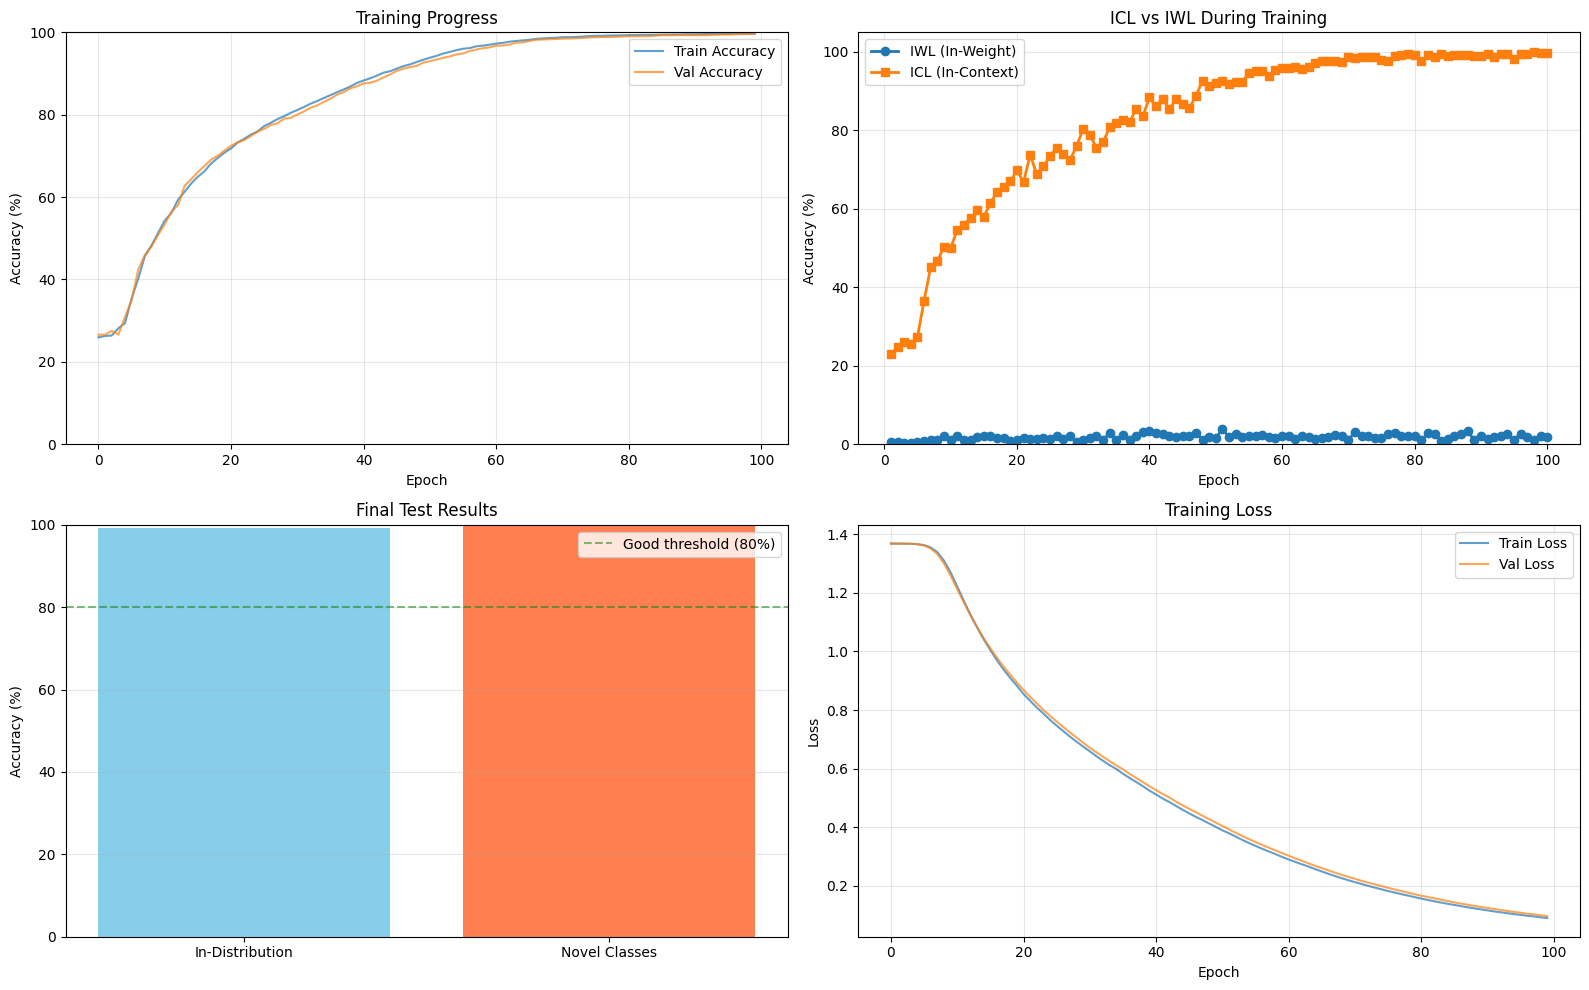


ICL/IWL SUMMARY
Final IWL Accuracy:        1.80%
Final ICL Accuracy:  99.80%


In [6]:
# Import from refactored modules
import torch
import numpy as np
import os
import time
from torch.utils.data import DataLoader

# Import from new modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data, generate_iwl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, RandomPolynomialICL, NonlinearMarkovICL
from training import train_model
from evaluation import test_icl
from config import ExperimentConfig

# ============================================================
# Data Generation Parameters
# ============================================================
L = 256                      # Number of output classes
K = 256                      # Number of GMM classes for data generation
D = 4                        # Dimension of input features
N = 4                        # Number of context examples per task
B = 1                        # Burstiness parameter (zipfian sampling weight)
epsilon = 1e-3               # Within-class noise (standard deviation)
seed = 20                    # Random seed for reproducibility
exact_copy = True            # If True, query is exact copy of a context item
shuffle_context = True       # Whether to shuffle context order during training
offset = 0.0                 # Offset applied to GMM centers
min_max_choice = None        # Optional constraint on min/max class indices
unique_labels = False        # If True, ensure all context labels are unique

# ============================================================
# Model Architecture Parameters
# ============================================================
n_nodes = 5                  # Number of nodes in the Markov chain
transform_func = 'exp'       # Transformation function: 'exp', 'relu', or 'elu'
learn_base_rates_W = True    # If True, allow gradient updates to unmasked base rates for W
learn_base_rates_Y = False   # If True, allow gradient updates to unmasked base rates for Y
symmetrize_Y = True          # Whether to enforce Y_{i,j,k} = Y_{i,k,j} symmetry

# ============================================================
# Sparsity Parameters - K_params (context-dependent modulation)
# ============================================================
sparsity_rho_edge_K = 0.0    # Fraction of (i,j) edges with K parameters (0.0 = all masked)
sparsity_rho_all_K = 0.0     # Fraction of individual K parameters to keep (0.0 = all masked)

# ============================================================
# Sparsity Parameters - L_params (nonlinear interactions)
# ============================================================
sparsity_rho_edge_L = 1.0    # Fraction of (i,j,k) triplets with L parameters
sparsity_rho_all_L = 0.6    # Fraction of individual L parameters to keep

# ============================================================
# Sparsity Parameters - Base Rates
# ============================================================
sparsity_rho_edge_base_W = 1.0   # Fraction of (i,j) edges with base rates in W
sparsity_rho_edge_base_Y = 0.0  # Fraction of (i,j,k) triplets with base rates in Y
base_mask_value = float('-inf')  # Value for masked base rates: 0.0 (no bias) or float('-inf') (disable edge)

# ============================================================
# Training Parameters
# ============================================================
epochs = 100                 # Number of training epochs
lr = 0.0025                  # Learning rate
batch_size = 64              # Batch size for training
train_samples = 10000        # Number of training samples
val_samples = 2000           # Number of validation samples

# ============================================================
# Inference Parameters
# ============================================================
method = 'newton'            # Steady-state solver: 'newton', 'direct_solve', 'matrix_tree', 'linear_solver'
temperature = 1.0            # Softmax temperature for attention

# ============================================================
# Combined Parameter Dictionary
# ============================================================
params = {
    # Data generation
    'K': K,
    'L': L,
    'D': D,
    'N': N,
    'B': B,
    'epsilon': epsilon,
    'seed': seed,
    'exact_copy': exact_copy,
    'shuffle_context': shuffle_context,
    'offset': offset,
    'min_max_choice': min_max_choice,
    'unique_labels': unique_labels,
    
    # Model architecture
    'n_nodes': n_nodes,
    'transform_func': transform_func,
    'learn_base_rates_W': learn_base_rates_W,
    'learn_base_rates_Y': learn_base_rates_Y,
    'symmetrize_Y': symmetrize_Y,
            
    # Sparsity - K_params
    'sparsity_rho_edge_K': sparsity_rho_edge_K,
    'sparsity_rho_all_K': sparsity_rho_all_K,
    
    # Sparsity - L_params
    'sparsity_rho_edge_L': sparsity_rho_edge_L,
    'sparsity_rho_all_L': sparsity_rho_all_L,
    
    # Sparsity - Base rates
    'sparsity_rho_edge_base_W': sparsity_rho_edge_base_W,
    'sparsity_rho_edge_base_Y': sparsity_rho_edge_base_Y,
    'base_mask_value': base_mask_value,
    
    # Training
    'epochs': epochs,
    'lr': lr,
    'batch_size': batch_size,
    'train_samples': train_samples,
    'val_samples': val_samples,
    
    # Inference
    'method': method,
    'temperature': temperature
}


print("="*70)
print("MARKOV ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to L)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], L=params['L'], epsilon=params['epsilon'], seed=params['seed'], offset=params['offset'])
print(f"  GMM: {params['K']} classes with labels randomly assigned from {{1, ..., {params['L']}}}")
print(f"  First 10 class labels: {gmm.class_to_label[:min(10, params['K'])].numpy()}")

# Generate data
print("\nGenerating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], 
                                 B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = NonlinearMarkovICL(n_nodes=params['n_nodes'], z_dim=params['D'], 
                           L=params['L'], N=params['N'], 
                           learn_base_rates_W=params['learn_base_rates_W'],
                           learn_base_rates_Y=params['learn_base_rates_Y'], 
                           symmetrize_Y=params['symmetrize_Y'],
                           transform_func=params['transform_func'],
                           sparsity_rho_edge_K=params['sparsity_rho_edge_K'], 
                           sparsity_rho_all_K=params['sparsity_rho_all_K'],
                           sparsity_rho_edge_L=params['sparsity_rho_edge_L'], 
                           sparsity_rho_all_L=params['sparsity_rho_all_L'],
                           sparsity_rho_edge_base_W=params['sparsity_rho_edge_base_W'],
                           sparsity_rho_edge_base_Y=params['sparsity_rho_edge_base_Y'],
                           base_mask_value=params['base_mask_value'])

# Train with ICL/IWL tracking
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], 
                     method=params['method'], temperature=params['temperature'],
                     gmm=gmm, N=params['N'], B=params['B'], 
                     L=params['L'], exact_copy=params['exact_copy'],
                     eval_frequency=1, n_eval_samples=500, min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])
                     
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], 
                  method=params['method'], L=params['L'],
                  temperature=params['temperature'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

# # Save model
# os.makedirs('results', exist_ok=True)
# model_path = f'results/markov_icl_gmm_K{config.K}_N{config.N}_classification_T{config.temperature:.1f}.pt'
# torch.save(model.state_dict(), model_path)
# print(f"\n✓ Saved: {model_path}")

# Plot training history with ICL/IWL metrics
try:
    import matplotlib.pyplot as plt
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
    #icl_swap_acc = [val for val in history['icl_swap_acc'] if val is not None]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Training/Val Accuracy
    ax1 = axes[0, 0]
    ax1.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax1.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Plot 2: ICL vs IWL over time
    ax2 = axes[0, 1]
    if len(iwl_acc) > 0:
        ax2.plot(epochs_eval, iwl_acc, 'o-', label='IWL (In-Weight)', linewidth=2, markersize=6)
        ax2.plot(epochs_eval, icl_acc, 's-', label='ICL (In-Context)', linewidth=2, markersize=6)
        #ax2.plot(epochs_eval, icl_swap_acc, '^-', label='ICL Label Swap', linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('ICL vs IWL During Training')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 105])
    else:
        ax2.text(0.5, 0.5, 'No ICL/IWL data\n(set gmm parameter)', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Plot 3: Final test results
    ax3 = axes[1, 0]
    ax3.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Final Test Results')
    ax3.axhline(y=80, color='g', linestyle='--', label='Good threshold (80%)', alpha=0.5)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 100])
    
    # Plot 4: Training/Val Loss
    ax4 = axes[1, 1]
    ax4.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    ax4.plot(history['val_loss'], label='Val Loss', alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(iwl_acc) > 0:
        print("\n" + "="*70)
        print("ICL/IWL SUMMARY")
        print("="*70)
        print(f"Final IWL Accuracy:        {iwl_acc[-1]:.2f}%")
        print(f"Final ICL Accuracy:  {icl_acc[-1]:.2f}%")
        #print(f"Final ICL Swap Accuracy:   {icl_swap_acc[-1]:.2f}%")
        print("="*70)
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")

In [8]:
param1_values = np.arange(0.0, 0.4, 0.05)
param1_values = [round(s,2) for s in param1_values]
print(param1_values)

[np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35)]


In [5]:
# Get a single example from the training dataset
z_seq, labels, targets = train_loader.dataset[2000]

# Add batch dimension and move to device
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
targets = targets.unsqueeze(0).to(device).long() - 1  # Shape: (1,)

print("Example input:")
print(f"z_seq shape: {z_seq.shape}")
print(f"labels shape: {labels.shape}")
print(f"z_seq:\n{z_seq}")
print(f"labels: {labels}")

# Flatten z_seq as the model expects
z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
print(f"\nFlattened z shape: {z_flat.shape}")

# Compute the rate matrix W and rate tensor Y
model.eval()
with torch.no_grad():
    W_mat = model.compute_rate_matrix_W(z_flat)
    Y_tensor = model.compute_rate_tensor_Y(z_flat)

print(f"\nRate matrix W shape: {W_mat.shape}")
print(f"Rate matrix W:\n{W_mat[0]}")  # Print the first (and only) matrix in the batch

# Verify that columns sum to approximately zero (as they should for a rate matrix)
col_sums = W_mat[0].sum(dim=0)
print(f"\nColumn sums of W (should be ~0): {col_sums}")

print(f"\nRate tensor Y shape: {Y_tensor.shape}")
print(f"Rate tensor Y[0] (first batch):\n{Y_tensor[0]}")

# Verify the constraint: Y[j,j,k] = -sum_{i≠j} Y[i,j,k]
# Check for j=0, k=0 as an example
j, k = 0, 0
sum_off_diag = Y_tensor[0, :, j, k].sum() - Y_tensor[0, j, j, k]  # Sum excluding diagonal
print(f"\nConstraint check for Y[j={j},j={j},k={k}]:")
print(f"  Y[{j},{j},{k}] = {Y_tensor[0, j, j, k].item():.6f}")
print(f"  -Sum_{{i≠{j}}} Y[i,{j},{k}] = {-sum_off_diag.item():.6f}")
print(f"  Difference (should be ~0): {(Y_tensor[0, j, j, k] + sum_off_diag).item():.6e}")

# Compute steady state using nonlinear solver
n_iter = 50
step_size = 0.1

with torch.no_grad():
    p_steady = model.direct_solve_steady_state(W_mat, Y_tensor, n_iter=n_iter, step_size=step_size)

print(f"\nSteady state distribution (π):")
print(f"Shape: {p_steady.shape}")
print(f"π = {p_steady[0]}")
print(f"Sum of π (should be 1.0): {p_steady[0].sum().item()}")

# Verify the steady state: W p + p Y p should be approximately 0
with torch.no_grad():
    # Linear term: W @ p
    linear_term = torch.einsum("bij,bj->bi", W_mat, p_steady)
    
    # Quadratic term: sum_{j,k} Y[i,j,k] * p_j * p_k
    outer = p_steady.unsqueeze(2) * p_steady.unsqueeze(1)  # (batch_size, n, n)
    quadratic_term = torch.einsum("bijk,bjk->bi", Y_tensor, outer)
    
    # Total should be ~0
    total_drift = linear_term + quadratic_term
    
print(f"\nSteady state verification (W p + p Y p):")
print(f"Linear term (W @ p): {linear_term[0]}")
print(f"Quadratic term (p Y p): {quadratic_term[0]}")
print(f"Total (should be ~0): {total_drift[0]}")
print(f"Max absolute drift: {torch.abs(total_drift[0]).max().item():.6e}")

# Compute context position scores: q_m = Σ_k B_{k,m} * π_k
with torch.no_grad():
    q = torch.matmul(p_steady, model.B)  # (batch_size, N)
    attention = torch.softmax(q / temperature, dim=1)

print(f"\nContext position scores (q):")
print(f"q = {q[0]}")
print(f"\nAttention weights over context positions:")
print(f"attention = {attention[0]}")
print(f"Sum of attention (should be 1.0): {attention[0].sum().item()}")

# Optional: Also compute the full forward pass to see final output
with torch.no_grad():
    logits = model(z_seq, labels, method='direct_solve', temperature=temperature, 
                   n_iter=n_iter, step_size=step_size)
    probs = torch.exp(logits)  # Convert log-probs to probs
    predicted_class = logits.argmax(dim=1) + 1  # Convert back to 1-indexed
    
print(f"\nModel output:")
print(f"Logits shape: {logits.shape}")
print(f"Top 5 logits: {logits[0].topk(5)}")
print(f"Top 5 probabilities: {probs[0].topk(5)}")
print(f"Predicted class: {predicted_class.item()}")
print(f"True class: {targets.item() + 1}")
print(f"Correct: {predicted_class.item() == targets.item() + 1}")

Example input:
z_seq shape: torch.Size([1, 4, 4])
labels shape: torch.Size([1, 3])
z_seq:
tensor([[[-0.8241, -0.5217, -0.2238, -0.4998],
         [-0.7749,  0.6601, -0.0030,  0.2910],
         [-0.3386, -0.4822,  0.2816, -0.1609],
         [-0.7749,  0.6601, -0.0030,  0.2910]]])
labels: tensor([[132., 164.,  95.]])

Flattened z shape: torch.Size([1, 16])

Rate matrix W shape: torch.Size([1, 4, 4])
Rate matrix W:
tensor([[-7.2028e-01,  1.1353e-04,  1.9801e-01,  4.9022e-02],
        [ 1.0801e-01, -1.1610e+00,  2.0287e+00,  5.0523e-03],
        [ 8.4350e-02,  9.3691e-01, -2.4563e+00,  2.4969e-02],
        [ 5.2792e-01,  2.2401e-01,  2.2964e-01, -7.9043e-02]])

Column sums of W (should be ~0): tensor([ 0.0000e+00, -4.4703e-08, -5.9605e-08,  0.0000e+00])

Rate tensor Y shape: torch.Size([1, 4, 4, 4])
Rate tensor Y[0] (first batch):
tensor([[[-5.7862e-22, -5.7862e-22, -5.7862e-22, -5.7862e-22],
         [ 1.9287e-22,  1.9287e-22,  1.9287e-22,  1.9287e-22],
         [ 1.9287e-22,  1.9287e-22,

In [3]:
def direct_solve_steady_state_ext(model, W_batch, Y_batch, n_iter=50, step_size=0.05, eps=1e-12):
        """
        Solve nonlinear steady state using fixed-point iteration (gradient descent).
        
        Solves: W p + p Y p = 0 with sum(p) = 1 and p >= 0
        where (p Y p)_i = sum_{j,k} Y[i,j,k] p_j p_k
        
        Uses gradient descent to minimize ||W p + p Y p||, projecting onto the probability simplex.
        
        Args:
            W_batch: (batch_size, n_nodes, n_nodes) - linear rate matrix
            Y_batch: (batch_size, n_nodes, n_nodes, n_nodes) - nonlinear rate tensor
            n_iter: Number of fixed-point iterations (default: 50)
            step_size: Step size for gradient descent (default: 0.1)
            eps: Minimum value for clamping (default: 1e-12)
            
        Returns:
            p_batch: (batch_size, n_nodes) - steady state distributions
        """
        batch_size, n = W_batch.shape[0], model.n_nodes
        device = W_batch.device
        
        # Initialize from uniform distribution
        p_batch = torch.full((batch_size, n), 1.0/n, device=device)
        
        for _ in range(n_iter):
            # Compute quadratic term: Q_i = sum_{j,k} Y[i,j,k] p_j p_k
            # Outer product: p_j * p_k
            outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)  # (batch_size, n, n)
            Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)  # (batch_size, n)
            
            # Compute linear term: L_i = sum_j W[i,j] p_j
            L = torch.einsum("bij,bj->bi", W_batch, p_batch)  # (batch_size, n)
            
            # Total drift function F = W p + p Y p
            F = L + Q  # (batch_size, n)
            
            # Gradient descent step toward F(p) = 0
            p_batch = p_batch + step_size * F
            
            # Project onto probability simplex: clamp and normalize
            p_batch = torch.clamp(p_batch, min=eps)
            p_batch = p_batch / p_batch.sum(dim=1, keepdim=True)
        
        # Handle NaN/Inf (fallback to uniform)
        mask = torch.isnan(p_batch).any(dim=1) | torch.isinf(p_batch).any(dim=1)
        if mask.any():
            p_batch[mask] = 1.0 / n
        
        return p_batch


def direct_solve_steady_state_ext_mom(model, W_batch, Y_batch, n_iter=50, step_size=0.05, eps=1e-12, tol=1e-6, momentum=0.3):
        """
        Solve nonlinear steady state using fixed-point iteration (gradient descent).
        
        Solves: W p + p Y p = 0 with sum(p) = 1 and p >= 0
        where (p Y p)_i = sum_{j,k} Y[i,j,k] p_j p_k
        
        Uses gradient descent to minimize ||W p + p Y p||, projecting onto the probability simplex.
        
        Args:
            W_batch: (batch_size, n_nodes, n_nodes) - linear rate matrix
            Y_batch: (batch_size, n_nodes, n_nodes, n_nodes) - nonlinear rate tensor
            n_iter: Number of fixed-point iterations (default: 50)
            step_size: Step size for gradient descent (default: 0.1)
            eps: Minimum value for clamping (default: 1e-12)
            
        Returns:
            p_batch: (batch_size, n_nodes) - steady state distributions
        """
        batch_size, n = W_batch.shape[0], model.n_nodes
        device = W_batch.device
        
        # Initialize from uniform distribution
        p_batch = torch.full((batch_size, n), 1.0/n, device=device)
        
        # Momentum buffer
        velocity = torch.zeros_like(p_batch)
        
        for iter_idx in range(n_iter):
            # Compute quadratic term: Q_i = sum_{j,k} Y[i,j,k] p_j p_k
            outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)  # (batch_size, n, n)
            Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)  # (batch_size, n)
            
            # Compute linear term: L_i = sum_j W[i,j] p_j
            # Using bmm is slightly faster than einsum for matrix-vector multiply
            L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)  # (batch_size, n)
            
            # Total drift function F = W p + p Y p
            F = L + Q  # (batch_size, n)
            
            # Check for early convergence (optional)
            max_drift = torch.abs(F).max().item()
            if max_drift < tol:
                break
            
            # Momentum update
            velocity = momentum * velocity + step_size * F
            p_batch = p_batch + velocity
            
            # Project onto probability simplex: clamp and normalize
            p_batch = torch.clamp(p_batch, min=eps)
            p_batch = p_batch / p_batch.sum(dim=1, keepdim=True)
        
        # Handle NaN/Inf (fallback to uniform)
        mask = torch.isnan(p_batch).any(dim=1) | torch.isinf(p_batch).any(dim=1)
        if mask.any():
            p_batch[mask] = 1.0 / n
        
        return p_batch

def newton_steady_state(model, W_batch, Y_batch, n_iter=10, eps=1e-12, tol=1e-8):
    """
    Newton's method for solving W p + p Y p = 0.
    
    Much faster convergence (typically 5-10 iterations vs 50+)
    """
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize from uniform distribution
    p_batch = torch.full((batch_size, n), 1.0/n, device=device)
    
    for _ in range(n_iter):
        # Compute F(p) = W p + p Y p
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)
        F = L + Q
        
        # Check convergence
        if torch.abs(F).max() < tol:
            break
        
        # Compute Jacobian: J[i,j] = dF_i/dp_j
        # J = W + (Y[:,:,j,k] + Y[:,i,k,j]) * p_k (summed over k)
        # For quadratic term: d/dp_j (sum_k,l Y[i,k,l] p_k p_l) = sum_l Y[i,j,l]*p_l + sum_k Y[i,k,j]*p_k
        
        # Simplified: J = W + 2 * (Y contracted with p on last index)
        Y_p_contract = torch.einsum("bijk,bk->bij", Y_batch, p_batch)  # (b, n, n)
        Y_p_contract_T = torch.einsum("bijk,bj->bik", Y_batch, p_batch)  # (b, n, n)
        J = W_batch + Y_p_contract + Y_p_contract_T  # (batch, n, n)
        
        # Add constraint: last row enforces sum(p) = 1
        J_constrained = J.clone()
        J_constrained[:, -1, :] = 1.0
        
        # RHS
        b = -F
        b[:, -1] = 1.0 - p_batch.sum(dim=1)  # Enforce sum constraint
        
        # Solve J * delta_p = -F
        delta_p = torch.linalg.solve(J_constrained, b)
        
        # Update with line search damping
        alpha = 1.0
        p_new = p_batch + alpha * delta_p
        p_new = torch.clamp(p_new, min=eps)
        p_new = p_new / p_new.sum(dim=1, keepdim=True)
        
        p_batch = p_new

    # Verify steady state quality
    with torch.no_grad():
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p_batch)
        F_final = L + Q
        max_drift = torch.abs(F_final).max().item()
        
        
        if max_drift > 1e-3:
            print(f"WARNING: Newton steady state did not converge properly!")
            print(f"  Max drift: {max_drift:.2e} (threshold: 1e-3)")
            print(f"  Iterations: {n_iter}")
        
    return p_batch



def odeint_steady_state(model, W_batch, Y_batch, t_end=10.0, eps=1e-12, rtol=1e-8, atol=1e-8, method='dopri5', options = None, init_steps = 0):
    """
    Solve for steady state by integrating dp/dt = -(W p + p Y p) using adaptive ODE solver.
    
    Uses torchdiffeq (pip install torchdiffeq) with adaptive methods like:
    - 'dopri5': Dormand-Prince 5th order (default, similar to LSODA)
    - 'adaptive_heun': 2nd order adaptive
    - 'bosh3': Bogacki-Shampine 3rd order
    
    Automatically adjusts step size for efficiency and accuracy.
    
    Args:
        W_batch: (batch_size, n_nodes, n_nodes) - linear rate matrix
        Y_batch: (batch_size, n_nodes, n_nodes, n_nodes) - nonlinear rate tensor
        t_end: Integration time horizon (default: 10.0)
        eps: Minimum value for clamping (default: 1e-12)
        tol: Tolerance for ODE solver (default: 1e-8)
        method: ODE solver method (default: 'dopri5')
        
    Returns:
        p_batch: (batch_size, n_nodes) - steady state distributions
    """
    try:
        from torchdiffeq import odeint
    except ImportError:
        raise ImportError("Please install torchdiffeq: pip install torchdiffeq")
    
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize from uniform distribution
    p0 = torch.full((batch_size, n), 1.0/n, device=device)

    p_init = p0.clone()
    
    for _ in range(init_steps):
        # Compute W @ p (linear steady state residual)
        F = torch.bmm(W_batch, p_init.unsqueeze(-1)).squeeze(-1)
        
        # Gradient descent step (differentiable)
        p_init = p_init - 0.05 * F
        
        # Project to simplex (differentiable)
        p_init = torch.clamp(p_init, min=1e-12)
        p_init = p_init / p_init.sum(dim=1, keepdim=True)
    
    p0 = p_init.detach()  # Detach for ODE solver initial condition
    
    
    def compute_drift(t, p):
        """Compute dp/dt = -(W p + p Y p)"""
        outer = p.unsqueeze(2) * p.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p)
        F = L + Q
        return F  # dp/dt = -F to reach F=0
    
    # Time span
    t = torch.tensor([0.0, t_end], device=device)
    
    # Integrate
    p_trajectory = odeint(compute_drift, p0, t, rtol=rtol, atol=atol, method=method, options = options)
    
    # Get final state
    p = p_trajectory[-1]  # Shape: (batch_size, n_nodes)
    
    # Verify steady state
    with torch.no_grad():
        outer = p.unsqueeze(2) * p.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p)
        F_final = L + Q
        max_drift = torch.abs(F_final).max().item()
        if max_drift > 1e-3:
            print(f"WARNING: ODE solver did not converge properly!")
            print(f"  Max drift: {max_drift:.2e} (threshold: 1e-3)")
            print(f"  Iterations: {n_iter}")
    
    return p


def fixed_point_steady_state(model, W_batch, Y_batch, n_iter=50, eps=1e-12, tol=1e-8, step_size=0.05):
    """
    Fixed-point iteration for solving W p + p Y p = 0.
    
    Uses gradient descent with simplex projection.
    """
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize from uniform distribution
    p_batch = torch.full((batch_size, n), 1.0/n, device=device)
    
    for _ in range(n_iter):
        # Compute F(p) = W p + p Y p
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)
        F = L + Q
        
        # Check convergence
        if torch.abs(F).max() < tol:
            break
        
        # Gradient descent step toward F(p) = 0
        p_batch = p_batch + step_size * F
        
        # Project onto probability simplex
        p_batch = torch.clamp(p_batch, min=eps)
        p_batch = p_batch / p_batch.sum(dim=1, keepdim=True)
    
    # Handle NaN/Inf (fallback to uniform)
    mask = torch.isnan(p_batch).any(dim=1) | torch.isinf(p_batch).any(dim=1)
    if mask.any():
        p_batch[mask] = 1.0 / n

    # Verify steady state quality
    with torch.no_grad():
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p_batch)
        F_final = L + Q
        max_drift = torch.abs(F_final).max().item()
        

        if max_drift > 1e-3:
            print(f"WARNING: Newton steady state did not converge properly!")
            print(f"  Max drift: {max_drift:.2e} (threshold: 1e-3)")
            print(f"  Iterations: {n_iter}")
    
    return p_batch

def fixed_point_steady_state_anderson(model, W_batch, Y_batch, n_iter=50, eps=1e-12, tol=1e-8, step_size=0.05, m=5, beta=1.0):
    """
    Fixed-point iteration with Anderson acceleration for solving W p + p Y p = 0.
    
    Anderson acceleration uses a history of previous iterates to accelerate convergence.
    
    Args:
        model: Model with n_nodes attribute
        W_batch: (batch_size, n_nodes, n_nodes) - linear rate matrix
        Y_batch: (batch_size, n_nodes, n_nodes, n_nodes) - nonlinear rate tensor
        n_iter: Number of iterations (default: 50)
        eps: Minimum value for clamping (default: 1e-12)
        tol: Convergence tolerance (default: 1e-8)
        step_size: Step size for gradient descent (default: 0.05)
        m: Anderson history depth (default: 5)
        beta: Mixing parameter, 1.0 = full Anderson, 0.0 = no acceleration (default: 1.0)
    
    Returns:
        p_batch: (batch_size, n_nodes) - steady state distributions
    """
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize from uniform distribution
    p_batch = torch.full((batch_size, n), 1.0/n, device=device)
    
    # Anderson acceleration storage
    G_hist = []  # History of iterates
    F_hist = []  # History of residuals
    
    for iter_idx in range(n_iter):
        # Compute F(p) = W p + p Y p
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)
        F = L + Q
        
        # Check convergence
        if torch.abs(F).max() < tol:
            break
        
        # Basic gradient descent step
        g_new = p_batch + step_size * F
        
        # Project onto probability simplex
        g_new = torch.clamp(g_new, min=eps)
        g_new = g_new / g_new.sum(dim=1, keepdim=True)
        
        # Store in history
        G_hist.append(g_new)
        F_hist.append(F)
        
        # Keep only last m iterates
        if len(G_hist) > m:
            G_hist.pop(0)
            F_hist.pop(0)
        
        # Apply Anderson acceleration if we have enough history
        if len(G_hist) >= 2:
            # Stack history: (history_len, batch_size, n)
            G_stack = torch.stack(G_hist, dim=0)  # (k, batch, n)
            F_stack = torch.stack(F_hist, dim=0)  # (k, batch, n)
            
            k = len(G_hist)
            
            # Compute residual differences: ΔF_i = F_i - F_{i-1}
            dF = F_stack[1:] - F_stack[:-1]  # (k-1, batch, n)
            
            # Solve least squares: min ||ΔF α||^2 for each batch element
            # We want: dF.T @ dF @ α = dF.T @ F_new
            # Shape: dF is (k-1, batch, n), need to solve for each batch separately
            
            p_anderson = []
            for b in range(batch_size):
                # Get this batch's data
                dF_b = dF[:, b, :].T  # (n, k-1)
                F_b = F_hist[-1][b:b+1].T  # (n, 1)
                
                # Solve least squares: dF_b.T @ dF_b @ α = dF_b.T @ F_b
                try:
                    # Compute α = (dF_b.T @ dF_b)^{-1} @ dF_b.T @ F_b
                    A = dF_b.T @ dF_b  # (k-1, k-1)
                    b_vec = dF_b.T @ F_b  # (k-1, 1)
                    
                    # Add small regularization for stability
                    A = A + 1e-8 * torch.eye(k-1, device=device)
                    
                    alpha = torch.linalg.solve(A, b_vec).squeeze()  # (k-1,)
                    
                    # Ensure alpha sums to 1
                    alpha = torch.cat([alpha, torch.tensor([1.0 - alpha.sum()], device=device)])
                    
                    # Compute accelerated iterate: p_new = Σ α_i * g_i
                    p_new_b = torch.sum(G_stack[:, b, :] * alpha.unsqueeze(-1), dim=0)
                    
                    # Mix with non-accelerated step
                    p_new_b = beta * p_new_b + (1 - beta) * g_new[b]
                    
                    p_anderson.append(p_new_b)
                    
                except:
                    # If solve fails, fall back to non-accelerated
                    p_anderson.append(g_new[b])
            
            p_batch = torch.stack(p_anderson, dim=0)
            
            # Re-project to ensure validity
            p_batch = torch.clamp(p_batch, min=eps)
            p_batch = p_batch / p_batch.sum(dim=1, keepdim=True)
        else:
            # Not enough history, use standard step
            p_batch = g_new
    
    # Handle NaN/Inf (fallback to uniform)
    mask = torch.isnan(p_batch).any(dim=1) | torch.isinf(p_batch).any(dim=1)
    if mask.any():
        p_batch[mask] = 1.0 / n
    
    # Verify steady state
    with torch.no_grad():
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p_batch)
        F_final = L + Q
        max_drift = torch.abs(F_final).max().item()
        if max_drift > 1e-3:
            print(f"WARNING: Anderson solver did not converge properly!")
            print(f"  Max drift: {max_drift:.2e} (threshold: 1e-3)")
            print(f"  Iterations: {iter_idx + 1}/{n_iter}")
    
    return p_batch


def sqp_steady_state(model, W_batch, Y_batch, n_iter=50, eps=1e-12, tol=1e-8):
    """
    Sequential Quadratic Programming - handles constraints naturally.
    More robust than projection-based methods.
    """
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize
    p_batch = torch.full((batch_size, n), 1.0/n, device=device)
    
    for iteration in range(n_iter):
        # Compute F(p) = W p + p Y p
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)
        F = L + Q
        
        # Check convergence
        max_drift = torch.abs(F).max().item()
        if max_drift < tol:
            break
        
        # Compute Jacobian
        Y_p_contract = torch.einsum("bijk,bk->bij", Y_batch, p_batch)
        Y_p_contract_T = torch.einsum("bijk,bj->bik", Y_batch, p_batch)
        J = W_batch + Y_p_contract + Y_p_contract_T
        
        # Solve constrained QP: min ||J*dp + F||^2 s.t. sum(dp)=0, p+dp>=0
        # Simplified: use projected Newton with trust region
        
        # Try to solve J * dp = -F with constraint sum(dp) = 0
        J_aug = torch.cat([J, torch.ones(batch_size, 1, n, device=device)], dim=1)
        F_aug = torch.cat([F, torch.zeros(batch_size, 1, device=device)], dim=1)
        
        try:
            # Least squares solve
            dp = torch.linalg.lstsq(J_aug, -F_aug).solution
        except:
            # Fallback to gradient descent
            dp = -0.1 * F
        
        # Line search with trust region
        alpha = 1.0
        for _ in range(10):
            p_new = p_batch + alpha * dp
            
            # Project to simplex
            p_new = torch.clamp(p_new, min=eps)
            p_new = p_new / p_new.sum(dim=1, keepdim=True)
            
            # Check if improvement
            outer_new = p_new.unsqueeze(2) * p_new.unsqueeze(1)
            Q_new = torch.einsum("bijk,bjk->bi", Y_batch, outer_new)
            L_new = torch.bmm(W_batch, p_new.unsqueeze(-1)).squeeze(-1)
            F_new = L_new + Q_new
            
            if (F_new ** 2).sum() < (F ** 2).sum():
                break
            alpha *= 0.5
        
        p_batch = p_new
    
    with torch.no_grad():
        if max_drift > 1e-3:
            print(f"WARNING: SQP did not converge! Max drift: {max_drift:.2e}")
    
    return p_batch

def newton_steady_state_log_param(model, W_batch, Y_batch, n_iter=20, tol=1e-6):
    """
    Newton's method for solving W p + p Y p = 0 using log parameterization.
    
    Uses p = softmax(u) to automatically satisfy constraints p >= 0, sum(p) = 1.
    This avoids the need for clamping and projection.
    
    Args:
        model: Model with n_nodes attribute
        W_batch: (batch_size, n_nodes, n_nodes) - linear rate matrix
        Y_batch: (batch_size, n_nodes, n_nodes, n_nodes) - nonlinear rate tensor
        n_iter: Number of Newton iterations (default: 20)
        tol: Convergence tolerance (default: 1e-6)
        
    Returns:
        p_batch: (batch_size, n_nodes) - steady state distributions
    """
    batch_size, n = W_batch.shape[0], model.n_nodes
    device = W_batch.device
    
    # Initialize u such that p = softmax(u) = uniform
    # For uniform: u = zeros works
    u_batch = torch.zeros((batch_size, n), device=device)
    
    for iter_idx in range(n_iter):
        # Compute p = softmax(u)
        p_batch = torch.softmax(u_batch, dim=1)
        
        # Compute F(p) = W p + p Y p
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.bmm(W_batch, p_batch.unsqueeze(-1)).squeeze(-1)
        F = L + Q
        
        # Check convergence
        max_drift = torch.abs(F).max().item()
        if max_drift < tol:
            break
        
        # Compute Jacobian in p-space: J_p[i,j] = dF_i/dp_j
        Y_p_contract = torch.einsum("bijk,bk->bij", Y_batch, p_batch)
        Y_p_contract_T = torch.einsum("bijk,bj->bik", Y_batch, p_batch)
        J_p = W_batch + Y_p_contract + Y_p_contract_T  # (batch, n, n)
        
        # Transform to u-space using chain rule: dF/du = dF/dp * dp/du
        # For p = softmax(u): dp_i/du_j = p_i * (δ_ij - p_j)
        # This gives: J_u = J_p @ diag(p) @ (I - p p^T)
        
        # More efficient computation:
        # J_u = diag(p) @ J_p^T @ (I - p p^T)
        # For solving: J_u @ delta_u = -F
        # We need: (I - p p^T) @ diag(p) @ J_p^T @ delta_u = -F
        
        # Actually, let's use: J_u[i,j] = sum_k J_p[i,k] * p_k * (δ_kj - p_j)
        #                              = J_p[i,j] * p_j - (J_p @ p)_i * p_j
        # In matrix form: J_u = diag(J_p @ p) @ p^T + diag(p) @ J_p^T - p @ p^T @ diag(p) @ J_p^T
        
        # Simpler: J_u = J_p @ (diag(p) - p @ p^T)
        # where (diag(p) - p @ p^T) is the Jacobian of softmax
        
        p_diag = torch.diag_embed(p_batch)  # (batch, n, n)
        pp_outer = p_batch.unsqueeze(-1) @ p_batch.unsqueeze(-2)  # (batch, n, n)
        softmax_jac = p_diag - pp_outer  # (batch, n, n)
        
        J_u = torch.bmm(J_p, softmax_jac)  # (batch, n, n)
        
        # The system is singular (sum of columns = 0 due to softmax structure)
        # We need to add a constraint. Use: last row = e^T (sum constraint)
        J_u_constrained = J_u.clone()
        J_u_constrained[:, -1, :] = 1.0
        
        # RHS: we want F(p) = 0, but also maintain sum(p) = 1
        b = -F
        b[:, -1] = 0.0  # Sum constraint already satisfied by softmax
        
        # Solve for delta_u
        try:
            delta_u = torch.linalg.solve(J_u_constrained, b)
        except:
            # If singular, fall back to gradient descent in u-space
            # Gradient is: grad_u F = softmax_jac^T @ grad_p F = softmax_jac^T @ F
            grad_u = torch.bmm(softmax_jac.transpose(1, 2), F.unsqueeze(-1)).squeeze(-1)
            delta_u = -0.1 * grad_u
        
        # Update (no need for line search usually, softmax handles constraints)
        u_batch = u_batch + delta_u
    
    # Final p from softmax
    p_batch = torch.softmax(u_batch, dim=1)
    
    # Verify convergence
    with torch.no_grad():
        outer = p_batch.unsqueeze(2) * p_batch.unsqueeze(1)
        Q = torch.einsum("bijk,bjk->bi", Y_batch, outer)
        L = torch.einsum("bij,bj->bi", W_batch, p_batch)
        F_final = L + Q
        max_drift = torch.abs(F_final).max().item()
        
        if max_drift > 1e-3:
            print(f"WARNING: Log-param Newton did not converge properly!")
            print(f"  Max drift: {max_drift:.2e} (threshold: 1e-3)")
            print(f"  Iterations: {iter_idx + 1}/{n_iter}")
    
    return p_batch


# Get a single example from the training dataset
z_seq, labels, targets = train_loader.dataset[200]

# Add batch dimension and move to device
z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
targets = targets.unsqueeze(0).to(device).long() - 1  # Shape: (1,)

# print("Example input:")
# print(f"z_seq shape: {z_seq.shape}")
# print(f"labels shape: {labels.shape}")
# print(f"z_seq:\n{z_seq}")
# print(f"labels: {labels}")

# Flatten z_seq as the model expects
z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
# print(f"\nFlattened z shape: {z_flat.shape}")

# Compute the rate matrix W and rate tensor Y
model.eval()
with torch.no_grad():
    W_mat = model.compute_rate_matrix_W(z_flat)
    Y_tensor = model.compute_rate_tensor_Y(z_flat)

print(f"\nRate matrix W shape: {W_mat.shape}")
print(f"Rate matrix W:\n{W_mat[0]}")  # Print the first (and only) matrix in the batch

# Verify that columns sum to approximately zero (as they should for a rate matrix)
col_sums = W_mat[0].sum(dim=0)
# print(f"\nColumn sums of W (should be ~0): {col_sums}")

# print(f"\nRate tensor Y shape: {Y_tensor.shape}")
# print(f"Rate tensor Y[0] (first batch):\n{Y_tensor[0]}")

# Verify the constraint: Y[j,j,k] = -sum_{i≠j} Y[i,j,k]
# Check for j=0, k=0 as an example
j, k = 0, 0
sum_off_diag = Y_tensor[0, :, j, k].sum() - Y_tensor[0, j, j, k]  # Sum excluding diagonal
# print(f"\nConstraint check for Y[j={j},j={j},k={k}]:")
# print(f"  Y[{j},{j},{k}] = {Y_tensor[0, j, j, k].item():.6f}")
# print(f"  -Sum_{{i≠{j}}} Y[i,{j},{k}] = {-sum_off_diag.item():.6f}")
# print(f"  Difference (should be ~0): {(Y_tensor[0, j, j, k] + sum_off_diag).item():.6e}")

# Compute steady state using nonlinear solver
n_iter = 20
step_size = 0.2

start_time = time.time()
for _ in range(100):
    with torch.no_grad():
        #p_steady = model.direct_solve_steady_state(W_mat, Y_tensor, n_iter=n_iter, step_size=step_size)
        #p_steady = model.newton_steady_state(W_mat, Y_tensor, n_iter=n_iter)
        #p_steady = anderson_steady_state(model, W_mat, Y_tensor, n_iter=n_iter)
        #p_steady = fixed_point_steady_state_anderson(model, W_mat, Y_tensor, n_iter=n_iter, step_size=step_size)
        
        #p_steady = fixed_point_steady_state(model, W_mat, Y_tensor, n_iter=n_iter, step_size=step_size)
        #p_steady = odeint_steady_state(model, W_mat, Y_tensor, t_end=30.0, rtol=1e-3, atol=1e-3, method='rk4', options = {'step_size': 0.5}, init_steps = 0)
        #p_steady = odeint_steady_state(model, W_mat, Y_tensor, t_end=30.0, rtol=1e-1, atol=1e-1, method='euler', options = {'step_size': 0.2}, init_steps = 0)
        #p_steady = odeint_steady_state_fast(model, W_mat, Y_tensor, tol=1e-8, method='euler', options = {'step_size': 1})
        #p_steady = lbfgs_steady_state(model, W_mat, Y_tensor, max_iter=100)
        #p_steady = lbfgs_steady_state_batch_differentiable(model, W_mat, Y_tensor, max_iter=100)
        #p_steady = sqp_steady_state(model, W_mat, Y_tensor, n_iter=20, tol=1e-10)
        p_steady = newton_steady_state_log_param(model, W_mat, Y_tensor, n_iter=n_iter)
       # p_steady = newton_steady_state(model, W_mat, Y_tensor, n_iter=n_iter)
        #p_steady = trust_region_newton_steady_state(model, W_mat, Y_tensor, n_iter=n_iter)
        #p_steady =  newton_steady_state_optimized(model, W_mat, Y_tensor, n_iter=n_iter, reg = 0)
        #p_steady = newton_steady_state(model,W_mat, Y_tensor, n_iter=n_iter)
        #p_steady = newton_steady_state(model, W_mat, Y_tensor, n_iter=n_iter)
        #p_steady = lbfgs_steady_state_batch(model, W_mat, Y_tensor, max_iter=n_iter, tol = )
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

print(f"\nSteady state distribution (π):")
print(f"Shape: {p_steady.shape}")
print(f"π = {p_steady[0]}")
print(f"Sum of π (should be 1.0): {p_steady[0].sum().item()}")

# Verify the steady state: W p + p Y p should be approximately 0
with torch.no_grad():
    # Linear term: W @ p
    linear_term = torch.einsum("bij,bj->bi", W_mat, p_steady)
    
    # Quadratic term: sum_{j,k} Y[i,j,k] * p_j * p_k
    outer = p_steady.unsqueeze(2) * p_steady.unsqueeze(1)  # (batch_size, n, n)
    quadratic_term = torch.einsum("bijk,bjk->bi", Y_tensor, outer)
    
    # Total should be ~0
    total_drift = linear_term + quadratic_term
    
print(f"\nSteady state verification (W p + p Y p):")
print(f"Linear term (W @ p): {linear_term[0]}")
print(f"Quadratic term (p Y p): {quadratic_term[0]}")
print(f"Total (should be ~0): {total_drift[0]}")
print(f"Max absolute drift: {torch.abs(total_drift[0]).max().item():.6e}")



Rate matrix W shape: torch.Size([1, 4, 4])
Rate matrix W:
tensor([[-1.0541e+00,  4.4392e-01,  1.2658e-01,  3.3767e-02],
        [ 4.9960e-01, -9.9720e-01,  1.9117e-01,  3.5778e-06],
        [ 5.5207e-01,  5.3368e-01, -6.2179e-01,  8.9779e-02],
        [ 2.3842e-03,  1.9600e-02,  3.0403e-01, -1.2355e-01]])
Time taken: 0.034948110580444336 seconds

Steady state distribution (π):
Shape: torch.Size([1, 4])
π = tensor([0.0852, 0.0913, 0.2365, 0.5869])
Sum of π (should be 1.0): 1.0

Steady state verification (W p + p Y p):
Linear term (W @ p): tensor([ 0.0004, -0.0032,  0.0014,  0.0014])
Quadratic term (p Y p): tensor([-0.0004,  0.0032, -0.0014, -0.0014])
Total (should be ~0): tensor([ 9.4587e-09,  3.9814e-08, -7.9977e-08,  3.5740e-08])
Max absolute drift: 7.997733e-08
